In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
block_plot = False

SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)


print(tf.__version__)


2023-08-04 07:09:22.003462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 07:09:23.909324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0


In [2]:
def sys_config():
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if(len(gpu_devices) > 0):
        print('Using GPU')
        os.environ['CUDA_VISIBLE_DEVICES'] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

In [3]:
def  get_data():
    mnist_data = tf.keras.datasets.mnist

    (X_train, y_train), (X_test, y_test) = mnist_data.load_data()
    return((X_train, y_train), (X_test, y_test))

In [4]:
def preprocess_data(train_set, test_set, resize_to=None, num_classes=10, seed=42):
    (X_train, y_train) = train_set
    (X_test, y_test)   = test_set

    # Split complete training data into vaidation data and training data-set
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, shuffle=True, stratify=y_train, test_size=0.1, random_state=seed)



    # Add an axis to gray scale image, not sure why ?
    if len(X_train.shape) != 4:
        X_train = tf.expand_dims(X_train, axis=3)
        X_validate = tf.expand_dims(X_validate, axis=3)
        X_test = tf.expand_dims(X_test, axis=3)

    # Re-size if requested via the command line parameters
    if resize_to:
        if isinstance(resize_to, int):
            resize_to = (resize_to, resize_to) 
        X_train    = tf.image.resize(X_train,    resize_to)
        X_validate = tf.image.resize(X_validate, resize_to)
        X_test     = tf.image.resize(X_test,     resize_to)

    n_train = X_train.shape[0]
    n_validate = X_validate.shape[0]
    n_test = X_test.shape[0]
    image_shape = X_train.shape[0]


    print('\n')
    print('There are {} training examples'.format(n_train))
    print('There are {} validation examples'.format(n_validate))
    print('There are {} test examples'.format(n_test))

    assert num_classes == len(np.unique(y_train)), "Mis-match in number of classes."
    print('There are {} classes'.format(num_classes))

    NUM_CLASSES = num_classes

    # One hot encoding of the output classes
    if len(y_train.shape) != 2:
        y_train    = tf.one_hot(y_train, NUM_CLASSES)
        y_validate = tf.one_hot(y_validate, NUM_CLASSES)
        y_test     = tf.one_hot(y_test, NUM_CLASSES)

    print('\nData split:\n')
    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_validate: {X_validate.shape}, y_validate: {y_validate.shape}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

    # Normalize the data
    X_train    = tf.cast(X_train, tf.float32) / 255.0
    X_validate = tf.cast(X_validate,tf.float32) / 255.0
    X_test     = tf.cast(X_test,tf.float32) / 255.0

    print('Ground truth has been one hot encoded')
    print(np.transpose(y_train[:9]))

    return(X_train, y_train), (X_validate,y_validate), (X_test,y_test)

In [5]:
def visualize_samples(X,y):
    plt.figure(figsize=(18,8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap='gray')
        plt.xlabel(y[i])
        plt.axis("off")
        
    plt.suptitle('Dataset Samples', fontsize=18)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show(block=block_plot)
    plt.close()

In [20]:
@dataclass(frozen=True)
class DatasetConfig:
    IMG_HEIGHT: int = 32
    IMG_WIDTH:  int = 32
    CHANNELS:   int = 1
    NUM_CLASSES: int = 10

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE: int = 32
    EPOCHS:     int = 1
    LEARNING_RATE: float = 0.01
    SEED: int = 42

data_config = DatasetConfig()
training_config = TrainingConfig()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


2023-08-04 07:09:40.175981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 07:09:40.682004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 07:09:40.682074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


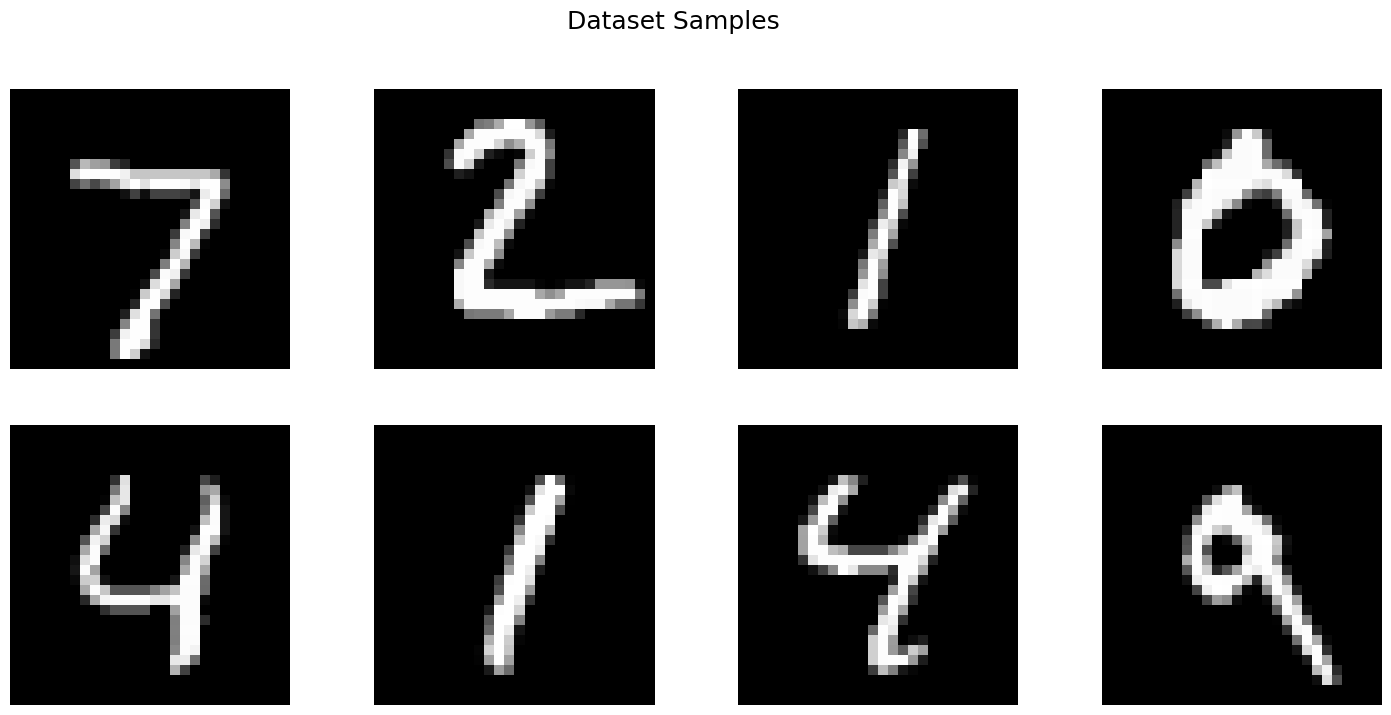

2023-08-04 07:09:41.548940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 07:09:41.549047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 07:09:41.549091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 07:09:44.022990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 07:09:44.023071: I tensorflow/compile



There are 54000 training examples
There are 6000 validation examples
There are 10000 test examples
There are 10 classes

Data split:

X_train: (54000, 32, 32, 1), y_train: (54000, 10)
X_validate: (6000, 32, 32, 1), y_validate: (6000, 10)
X_test: (10000, 32, 32, 1), y_test: (10000, 10)
Ground truth has been one hot encoded
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, Input, MaxPool2D

In [9]:
def LeNet_model(input_shape=(32,32,1), num_classes=10, print_summary=True):
    inputs = Input(shape=input_shape)

    # First CNN Layer
    x = Conv2D(6, 5, padding='valid')(inputs)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    # Second CNN layer
    x = Conv2D(16, 5, padding='valid')(x)
    x = Activation("relu")(x)
    feature_extractor_output = MaxPool2D()(x)

    # Flatten to send into an MLP
    flattened = Flatten()(feature_extractor_output)

    x = Dense(120, activation='relu')(flattened)
    x = Dense(84, activation='relu')(x)

    headout = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')

    if print_summary:
        model.summary()
        
    return model
    

In [10]:
def train_model(train_set, print_summary=False):
    (X_train, y_train) = train_set

    model = LeNet_model(input_shape=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH, data_config.CHANNELS),
                        num_classes=data_config.NUM_CLASSES,
                        print_summary=True)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=training_config.LEARNING_RATE), 
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

    results = model.fit(X_train, y_train, epochs=training_config.EPOCHS, batch_size=training_config.BATCH_SIZE,
                        validation_data=(X_validate,y_validate))

    return model, results
    

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                                                            

2023-08-04 07:09:48.498655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-04 07:09:51.936765: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2624003c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-04 07:09:51.936816: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2023-08-04 07:09:52.339860: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.8
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the env

1688/1688 [==============================] - 24s 9ms/step - loss: 0.5497 - accuracy: 0.8216 - val_loss: 0.1777 - val_accuracy: 0.9477
Epoch 2/21
1688/1688 [==============================] - 15s 9ms/step - loss: 0.1492 - accuracy: 0.9540 - val_loss: 0.1299 - val_accuracy: 0.9617
Epoch 3/21
1688/1688 [==============================] - 18s 10ms/step - loss: 0.1017 - accuracy: 0.9686 - val_loss: 0.0963 - val_accuracy: 0.9717
Epoch 4/21
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0821 - accuracy: 0.9740 - val_loss: 0.0985 - val_accuracy: 0.9692
Epoch 5/21
1688/1688 [==============================] - 16s 10ms/step - loss: 0.0684 - accuracy: 0.9782 - val_loss: 0.0782 - val_accuracy: 0.9773
Epoch 6/21
1688/1688 [==============================] - 16s 9ms/step - loss: 0.0597 - accuracy: 0.9813 - val_loss: 0.0780 - val_accuracy: 0.9730
Epoch 7/21
1688/1688 [==============================] - 16s 9ms/step - loss: 0.0539 - accuracy: 0.9826 - val_loss: 0.0722 - val_accuracy: 

In [36]:
from matplotlib.ticker import(MultipleLocator, FormatStrFormatter)
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15,4))

    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, training_config.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.show(block=block_plot)
    plt.close()
    

In [34]:
def evaluate_model(model, *test_set):
    X_test, y_test = test_set
    test_results = model.evaluate(X_test, y_test)
    random.seed(training_config.SEED)
    num_rows = 5
    num_cols = 5
    num_data = num_rows * num_cols
    shuffled_index = random.sample(range(y_test.shape[0]), num_data)
    X_sampled = tf.gather(X_test, shuffled_index)
    y_sampled = tf.gather(y_test, shuffled_index)

    y_pred_sampled = model.predict(X_sampled)
    num_matches = 0

    plt.figure(figsize=(18,12))
    for i in range(num_data):
        plt.subplot(num_rows, num_cols, i + 1)
        pred = np.argmax(y_pred_sampled[i])
        truth = np.argmax(y_sampled[i])
        title = 'True: ' + str(truth) + '; Pred: ' + str(pred)
        title_obj = plt.title(title, fontdict={'fontsize':16})
        if pred == truth:
            num_matches +=  1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')
        plt.axis("off")
        plt.imshow(X_sampled[i].numpy().squeeze(), cmap="gray")
    plt.show(block=block_plot)

    return test_results

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


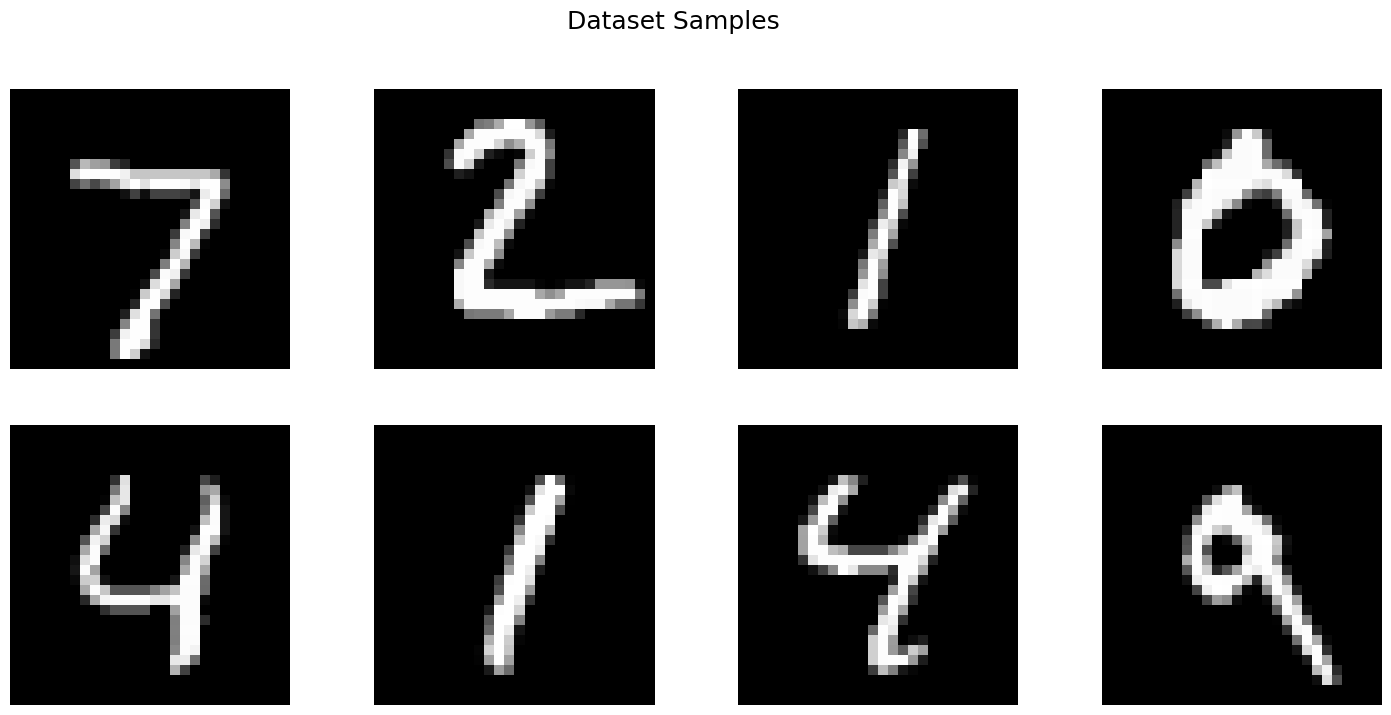



There are 54000 training examples
There are 6000 validation examples
There are 10000 test examples
There are 10 classes

Data split:

X_train: (54000, 32, 32, 1), y_train: (54000, 10)
X_validate: (6000, 32, 32, 1), y_validate: (6000, 10)
X_test: (10000, 32, 32, 1), y_test: (10000, 10)
Ground truth has been one hot encoded
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 6)         156       
                           

/tmp/ipykernel_570/3434759892.py:8: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, training_config.EPOCHS - 1])


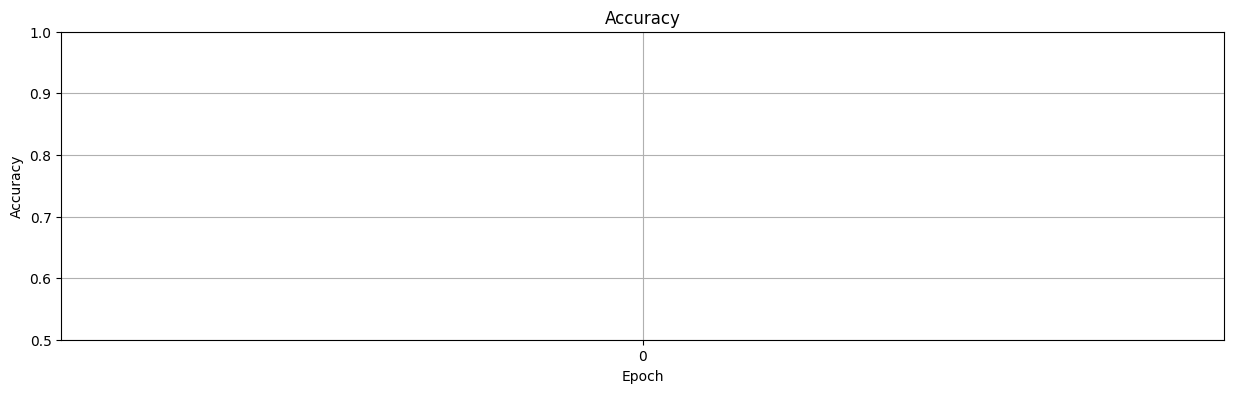

1/1 [==============================] - 0s 60ms/step


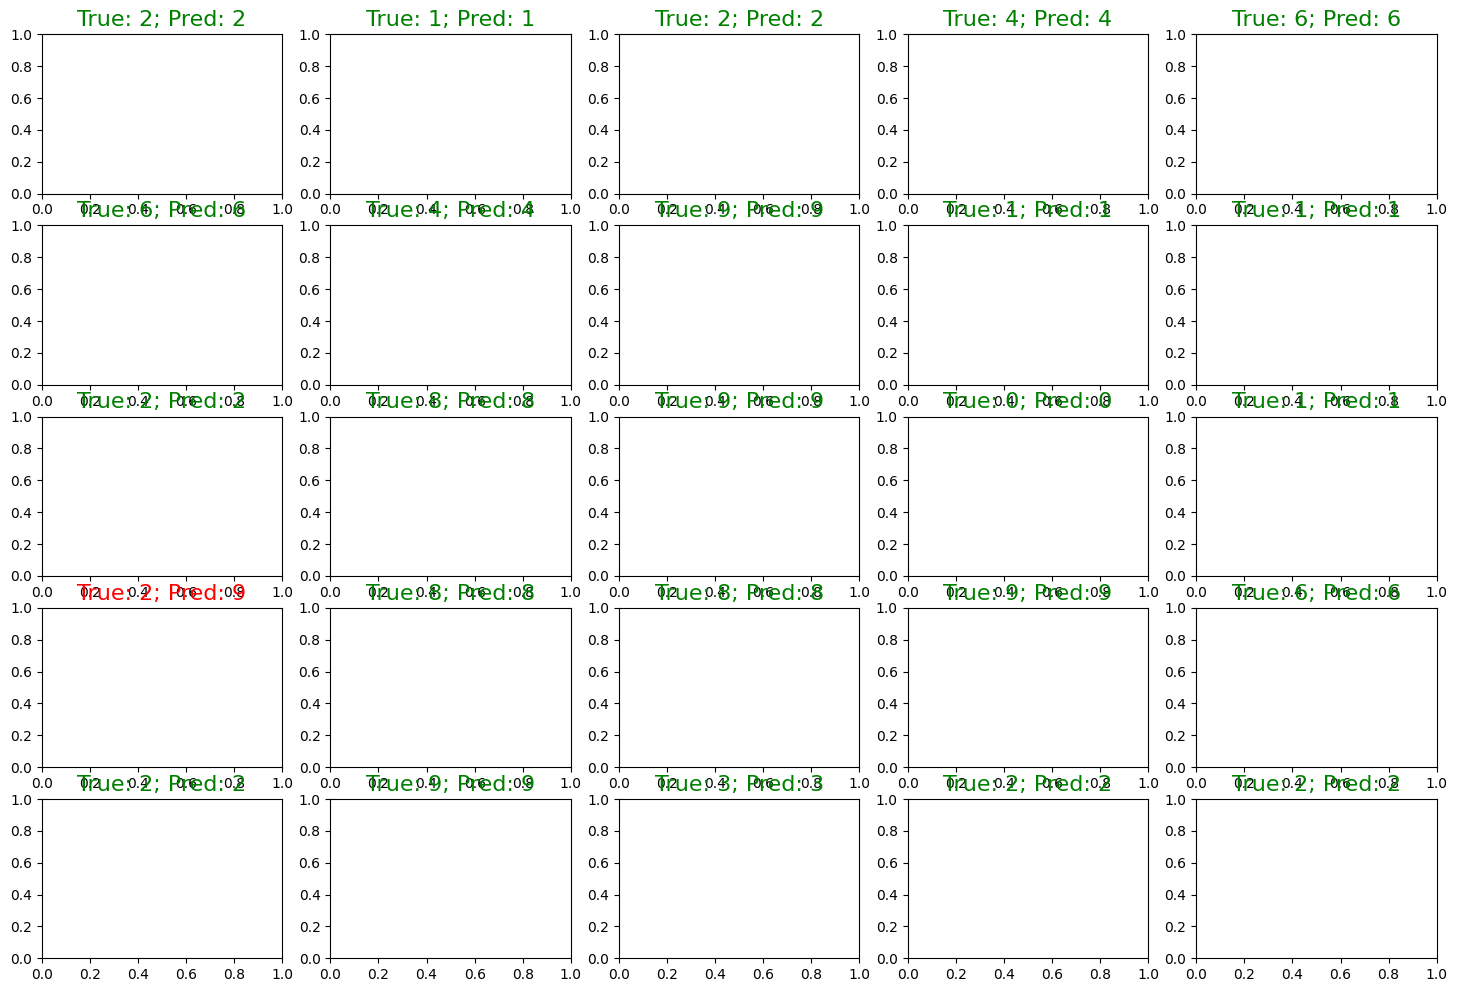

In [37]:
# MAIN 
# Trt 
sys_config()


(X_train_in, y_train_in), (X_test_in, y_test_in) = get_data()
visualize_samples(X_test_in,y_test_in)
((X_train, y_train), 
 (X_validate, y_validate), 
 (X_test, y_test)) = preprocess_data((X_train_in, y_train_in), 
                                     (X_test_in, y_test_in), 
                                     resize_to=(data_config.IMG_WIDTH, data_config.IMG_HEIGHT),
                                     num_classes=data_config.NUM_CLASSES)
model, training_results = train_model(train_set=(X_train, y_train), print_summary=True)
train_loss = training_results.history['loss']
train_acc = training_results.history['accuracy']
valid_loss = training_results.history['val_loss']
valid_acc = training_results.history['val_accuracy']
plot_results([train_acc, valid_acc], ylabel='Accuracy', ylim=[0.5,1.0])
test_set = (X_test, y_test)
test_results = evaluate_model(model, *test_set)
